### 1. Introduction

The purpose of this project is to look at what predictors actually effect the rate of shooting incidents that are associated with murders. I will be using a data set of shooting incidents in New York City provided by the New York Police Department.

### 2. Libraries

In [1]:
library(tidyverse)
library(lubridate)
library(ggplot2)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


### 3. Importing Data

I pull the .csv data from Data.gov and read it into R.

In [2]:
url <- "https://data.cityofnewyork.us/api/views/833y-fsy8/rows.csv"
nypd <- read_csv(url)

Rows: 27312 Columns: 21
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (12): OCCUR_DATE, BORO, LOC_OF_OCCUR_DESC, LOC_CLASSFCTN_DESC, LOCATION...
dbl   (7): INCIDENT_KEY, PRECINCT, JURISDICTION_CODE, X_COORD_CD, Y_COORD_CD...
lgl   (1): STATISTICAL_MURDER_FLAG
time  (1): OCCUR_TIME

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### 4. Cleaning Data

First, I remove the columns that will not be used in the analysis. They are: INCIDENT_KEY, LOCATION_DESC, Latitude, Longitude, Lon_Lat, X_COORD_CD, Y_COORD_CD and PRECINCT.

I will then check which columns have NA.

In [3]:
nypd <- nypd %>%
  select(-c(INCIDENT_KEY, LOCATION_DESC, Latitude, Longitude, Lon_Lat, 
            X_COORD_CD, Y_COORD_CD, PRECINCT))

In [4]:
colSums(is.na(nypd))

OCCUR_DATE              OCCUR_TIME                    BORO 
                      0                       0                       0 
      LOC_OF_OCCUR_DESC       JURISDICTION_CODE      LOC_CLASSFCTN_DESC 
                  25596                       2                   25596 
STATISTICAL_MURDER_FLAG          PERP_AGE_GROUP                PERP_SEX 
                      0                    9344                    9310 
              PERP_RACE           VIC_AGE_GROUP                 VIC_SEX 
                   9310                       0                       0 
               VIC_RACE 
                      0

In [5]:
nypd <- nypd %>%
  replace_na(list(PERP_AGE_GROUP = "U", 
               PERP_SEX = "U",
               PERP_RACE = "U")) %>%
  mutate_all(funs(str_replace(., "UNKNOWN", "U"))) %>%
  na.omit()

colSums(is.na(nypd))

Warning message:
“`funs()` was deprecated in dplyr 0.8.0.
ℹ Please use a list of either functions or lambdas:

# Simple named list: list(mean = mean, median = median)

# Auto named with `tibble::lst()`: tibble::lst(mean, median)

# Using lambdas list(~ mean(., trim = .2), ~ median(., na.rm = TRUE))”


OCCUR_DATE              OCCUR_TIME                    BORO 
                      0                       0                       0 
      LOC_OF_OCCUR_DESC       JURISDICTION_CODE      LOC_CLASSFCTN_DESC 
                      0                       0                       0 
STATISTICAL_MURDER_FLAG          PERP_AGE_GROUP                PERP_SEX 
                      0                       0                       0 
              PERP_RACE           VIC_AGE_GROUP                 VIC_SEX 
                      0                       0                       0 
               VIC_RACE 
                      0

By checking the summary of the data, we can check if the datatypes are appropriate.


In [6]:
summary(nypd)

  OCCUR_DATE         OCCUR_TIME            BORO           LOC_OF_OCCUR_DESC 
 Length:1716        Length:1716        Length:1716        Length:1716       
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
 JURISDICTION_CODE  LOC_CLASSFCTN_DESC STATISTICAL_MURDER_FLAG
 Length:1716        Length:1716        Length:1716            
 Class :character   Class :character   Class :character       
 Mode  :character   Mode  :character   Mode  :character       
 PERP_AGE_GROUP       PERP_SEX          PERP_RACE         VIC_AGE_GROUP     
 Length:1716        Length:1716        Length:1716        Length:1716       
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
   VIC_SEX            VIC_RACE        
 Length:1716        Length:1716       
 Class :character   Class :character  
 Mode  :charact

The following columns should be treated as a factor: **BORO, PRECINCT, JURISDICTION_CODE, PERP_AGE_GROUP, PERP_SEX, PERP_RACE, VIC_AGE_GROUP, VIC_SEX, VIC_RACE**. I will also read in the date correctly.

I also see that there are outliers in the **PERP_AGE_GROUP** category, with ages of 224, 940, and 1020. These numbers do not make sense, so I remove them and refactor that predictor.

In [7]:
nypd <- nypd %>%
  mutate(OCCUR_DATE = mdy(OCCUR_DATE)) %>%
  mutate_if(is.character, as.factor) %>%
  mutate_if(is.double, as.factor)

In [8]:
summary(nypd)

      OCCUR_DATE      OCCUR_TIME              BORO     LOC_OF_OCCUR_DESC
 2022-08-27:  25   13:30:00:  14   BRONX        :535   INSIDE : 242     
 2022-06-20:  22   00:10:00:  13   BROOKLYN     :568   OUTSIDE:1474     
 2022-07-04:  22   21:39:00:  12   MANHATTAN    :307                    
 2022-04-12:  21   23:57:00:  12   QUEENS       :266                    
 2022-07-02:  20   00:15:00:  11   STATEN ISLAND: 40                    
 2022-05-16:  19   00:36:00:  11                                        
 (Other)   :1587   (Other) :1643                                        
 JURISDICTION_CODE  LOC_CLASSFCTN_DESC STATISTICAL_MURDER_FLAG PERP_AGE_GROUP
 0:1488            STREET    :1103     FALSE:1378              (null):640    
 1:  15            HOUSING   : 280     TRUE : 338              <18   :128    
 2: 213            DWELLING  : 127                             18-24 :378    
                   COMMERCIAL: 100                             25-44 :485    
                   OTHER  

In [9]:
summary(nypd$PERP_AGE_GROUP)

(null)    <18  18-24  25-44  45-64    65+ 
   640    128    378    485     82      3

In [10]:
nypd <- subset(nypd, PERP_AGE_GROUP != "224" & PERP_AGE_GROUP != "940" &
                 PERP_AGE_GROUP != "1020")

In [11]:
nypd$PERP_AGE_GROUP <- factor(nypd$PERP_AGE_GROUP)

I want to see if shootings happen around a specific day or hour, so I create a column that stores the name of the day based on **OCCUR_DATE**, and another column that stores the hour based on **OCCUR_TIME**.

In [12]:
nypd <- nypd %>%
  mutate(DAY = wday(nypd$OCCUR_DATE, label = TRUE)) %>%
  mutate(HOUR = hour(hms(as.character(nypd$OCCUR_TIME))))

Warning message:
“There was 1 warning in `mutate()`.
ℹ In argument: `DAY = wday(nypd$OCCUR_DATE, label = TRUE)`.
Caused by warning:
! tz(): Don't know how to compute timezone for object of class factor; returning "UTC".”


In my final dataset, I remove the original **OCCUR_DATE** and **OCCUR_TIME** columns since I only want to look at **DAY** and **HOUR**.


In [13]:
nypd_clean <- nypd %>%
  select(-c(OCCUR_DATE, OCCUR_TIME))

In [14]:
murders_true <- subset(nypd_clean, STATISTICAL_MURDER_FLAG == TRUE)
murdres_false <- subset(nypd_clean, STATISTICAL_MURDER_FLAG == FALSE)

In [15]:
nypd_clean

BORO,LOC_OF_OCCUR_DESC,JURISDICTION_CODE,LOC_CLASSFCTN_DESC,STATISTICAL_MURDER_FLAG,PERP_AGE_GROUP,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,DAY,HOUR
<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<ord>,<dbl>
BROOKLYN,OUTSIDE,0,STREET,FALSE,(null),(null),(null),18-24,F,WHITE HISPANIC,Sat,22
BROOKLYN,OUTSIDE,0,STREET,FALSE,25-44,M,BLACK,25-44,M,BLACK,Mon,23
MANHATTAN,OUTSIDE,0,STREET,FALSE,(null),(null),(null),18-24,M,BLACK HISPANIC,Sun,3
BRONX,OUTSIDE,0,STREET,TRUE,18-24,M,BLACK HISPANIC,18-24,F,BLACK,Tue,22
BRONX,OUTSIDE,0,STREET,FALSE,25-44,M,WHITE HISPANIC,25-44,M,WHITE HISPANIC,Sat,4
BRONX,OUTSIDE,0,VEHICLE,FALSE,(null),(null),(null),25-44,M,WHITE HISPANIC,Sat,0
QUEENS,OUTSIDE,2,HOUSING,FALSE,(null),(null),(null),18-24,M,BLACK,Sat,19
BROOKLYN,INSIDE,0,DWELLING,FALSE,(null),(null),(null),25-44,F,BLACK,Thu,1
BRONX,OUTSIDE,0,STREET,FALSE,(null),(null),(null),45-64,M,BLACK,Mon,22


### 5. Visualizing

Below are some bar plots to see how certain factors relate to the number of shooting incidents.

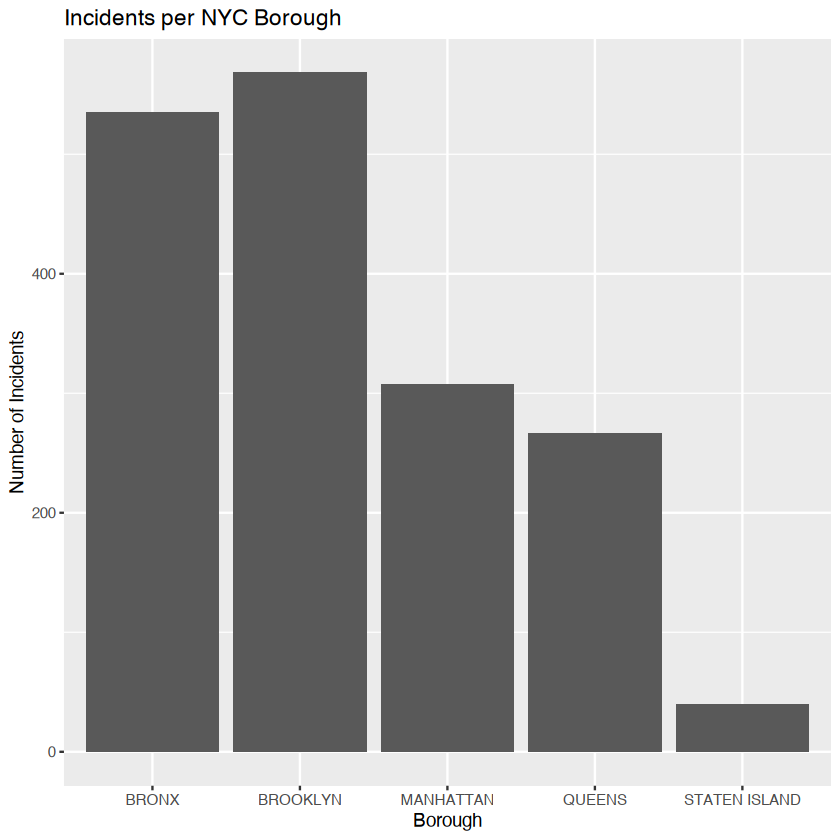

In [16]:
#plotting incidents in each borough
ggplot(nypd_clean, aes(x = BORO)) +
  geom_bar() +
  labs(title = "Incidents per NYC Borough",
       x = "Borough",
       y = "Number of Incidents")

By plotting the number of incidents in each borough, we see that Brooklyn has the most shooting incidents, while Staten Island has the least.

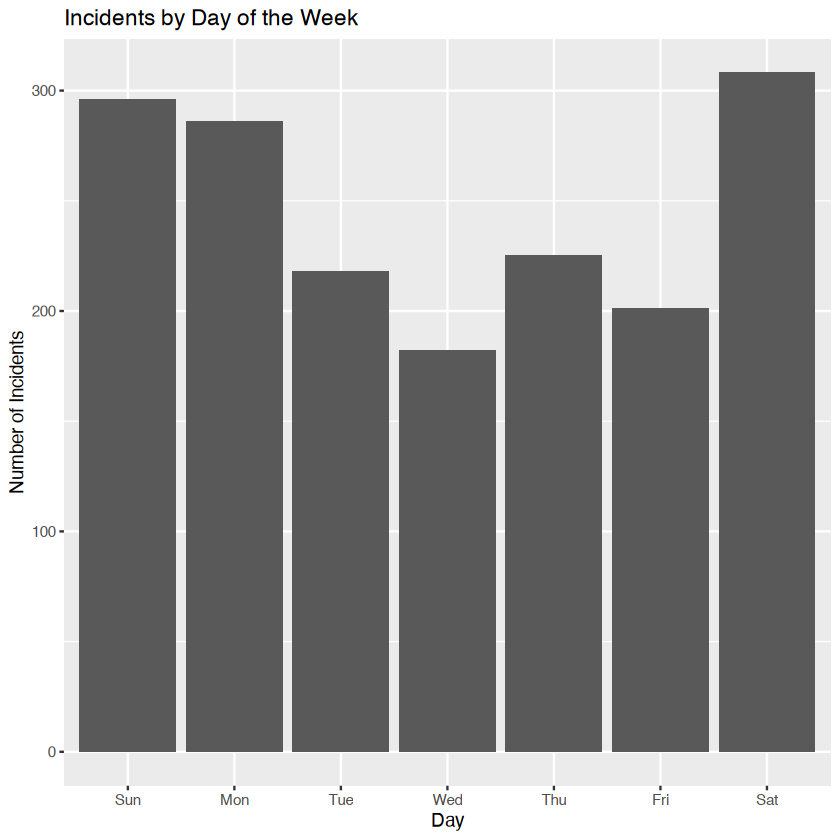

In [17]:
#plotting by day
ggplot(nypd_clean, aes(x = DAY)) +
  geom_bar() +
  labs(title = "Incidents by Day of the Week",
       x = "Day",
       y = "Number of Incidents")

We see that most shooting incidents occur on the weekend, rather than the weekdays.

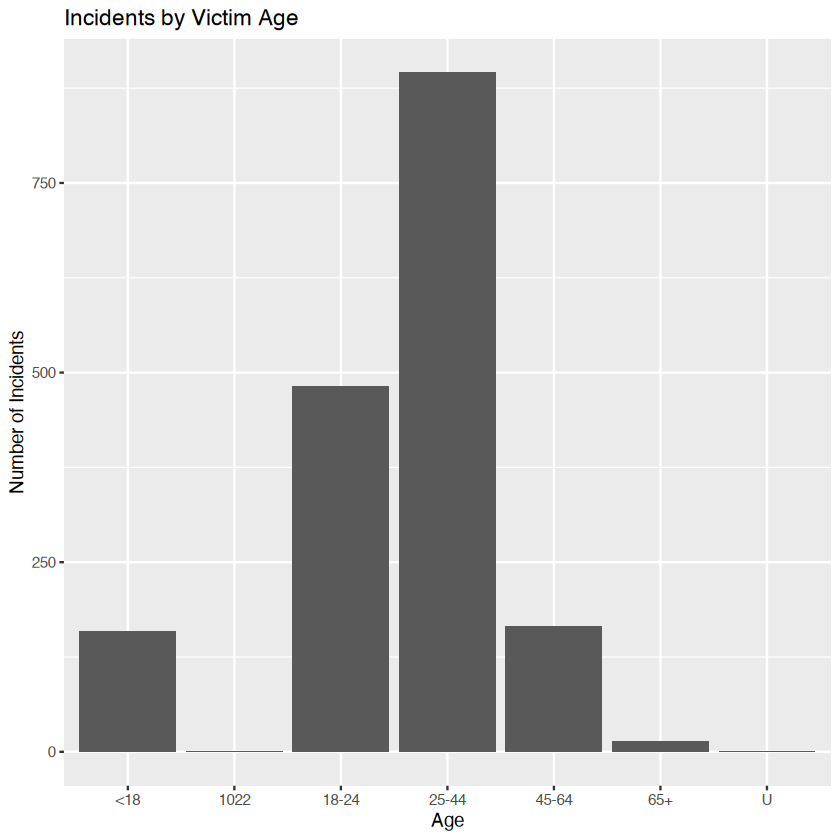

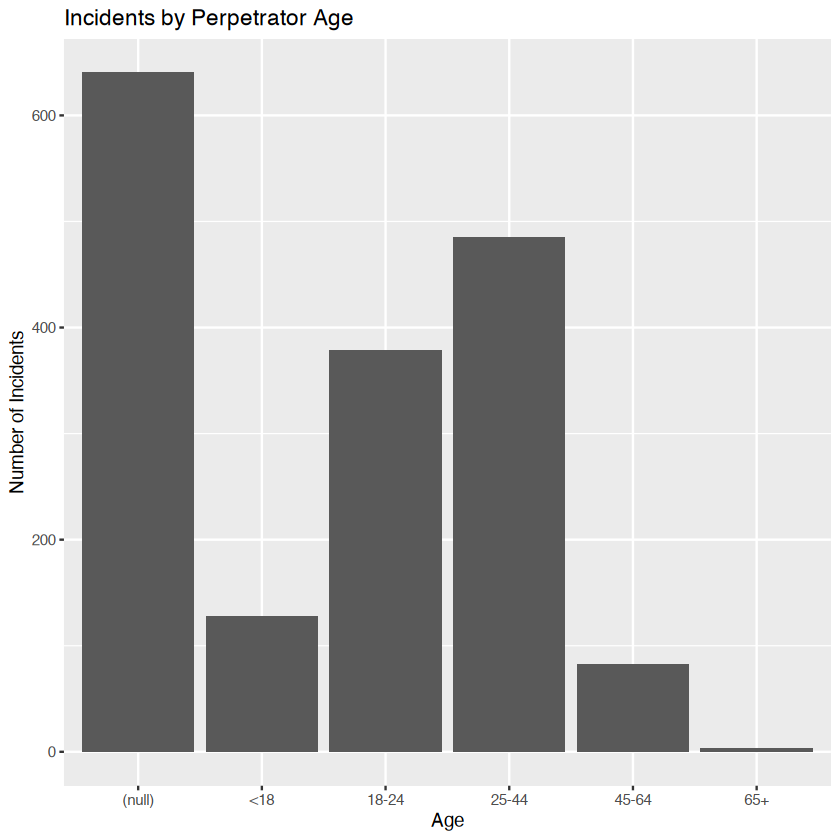

In [18]:
#plotting by age groups
ggplot(nypd_clean, aes(x = VIC_AGE_GROUP)) +
  geom_bar() +
  labs(title = "Incidents by Victim Age",
       x = "Age",
       y = "Number of Incidents")
       
ggplot(nypd_clean, aes(x = PERP_AGE_GROUP)) +
  geom_bar() +
  labs(title = "Incidents by Perpetrator Age",
       x = "Age",
       y = "Number of Incidents")

Most of the victims are under 45 years of age, while the age of most perpetrators is unknown.

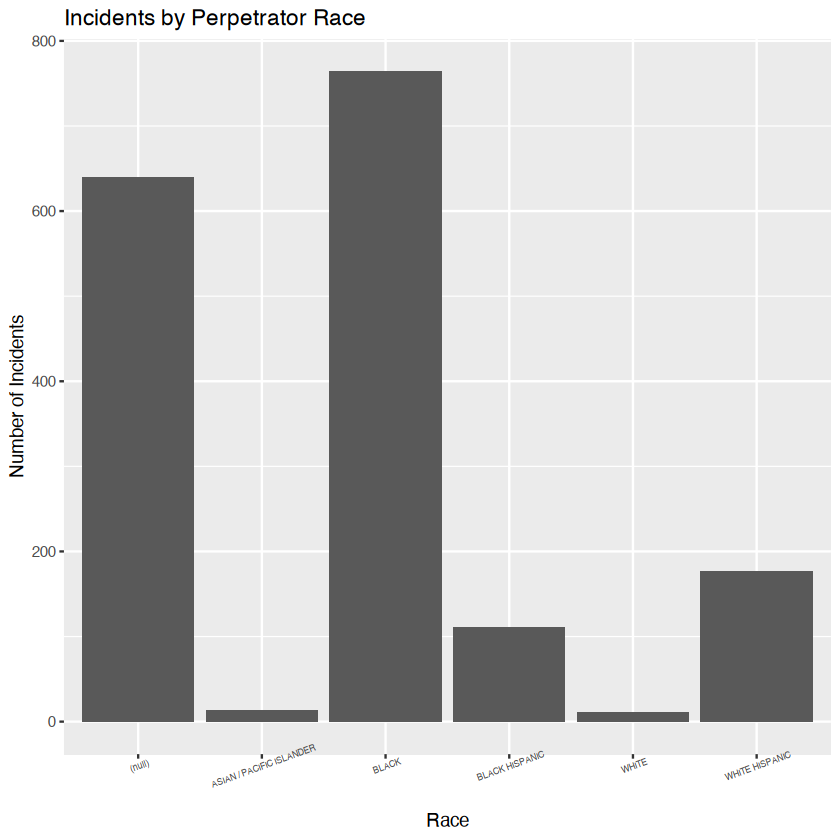

In [19]:
#plotting by race
ggplot(nypd_clean, aes(x = PERP_RACE)) +
  geom_bar() +
  labs(title = "Incidents by Perpetrator Race",
       x = "Race",
       y = "Number of Incidents") +
  theme(axis.text.x = element_text(angle = 20, size = 5))

By plotting incidents per race, we can see that out of the known perpetrators, the most incidents had a black perpetrator. However, one cannot ignore the fact that there's just as many unknown perpetrators.

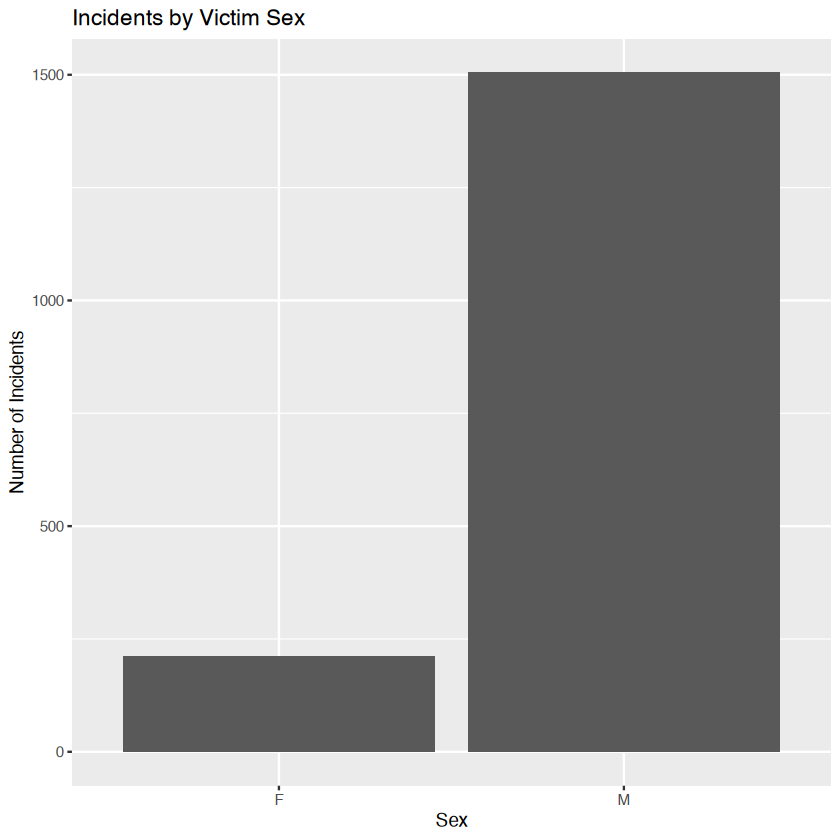

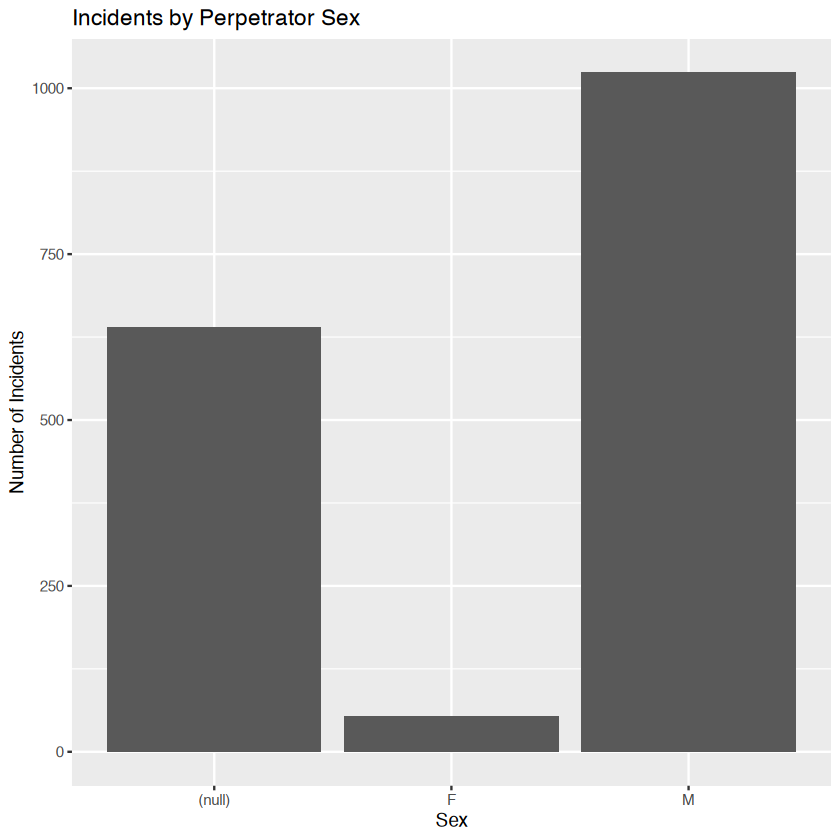

In [20]:
#plotting by sex
ggplot(nypd_clean, aes(x = VIC_SEX)) +
  geom_bar() +
  labs(title = "Incidents by Victim Sex",
       x = "Sex",
       y = "Number of Incidents")

ggplot(nypd_clean, aes(x = PERP_SEX)) +
  geom_bar() +
  labs(title = "Incidents by Perpetrator Sex",
       x = "Sex",
       y = "Number of Incidents")

Most of the victims are male, while most of the perpetrators are either male or unknown.

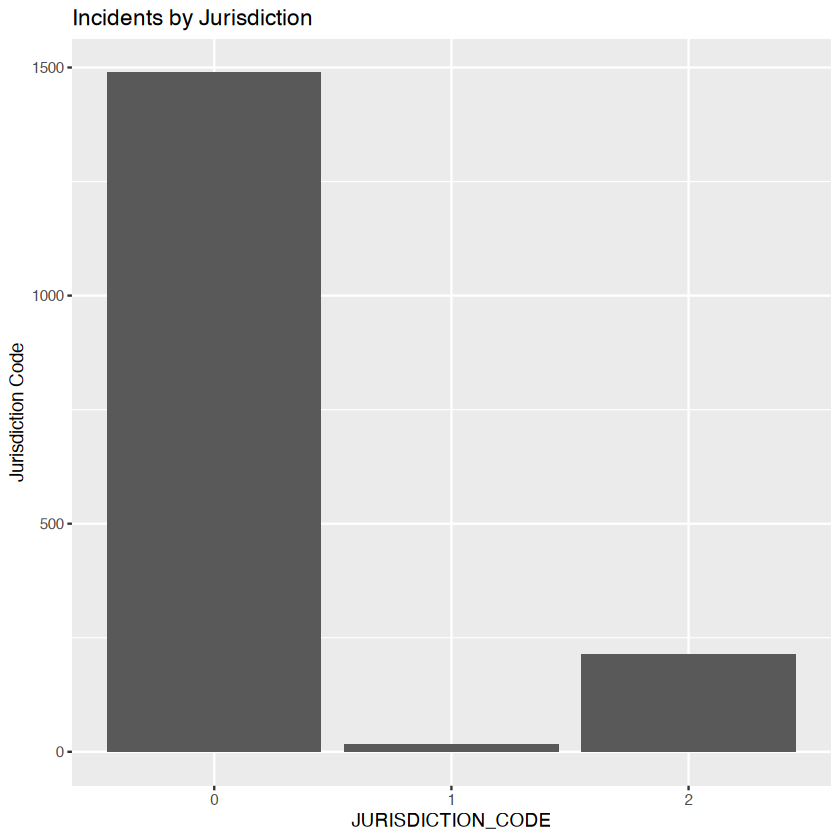

In [21]:
#plotting by jurisdiction
ggplot(nypd_clean, aes(x = JURISDICTION_CODE)) +
  geom_bar() +
  labs(title = "Incidents by Jurisdiction",
       x = "JURISDICTION_CODE",
       y = "Jurisdiction Code")

Overall, there is a large chunk of unknown data especially when it comes to perpetrator data. It would be interesting to see if these unknown perpetrators skews the results in any way.


### 6. Modeling

I use a Logistic Regression model to predict the probability of a murder associated with the shooting incident based on the different predictors.

Below is the result of running this model. The estimated coefficients of predictors in a logistic regression are associated with the expected change in natural log of odds that a murder is associated with a shooting incident. The predictors in this model are categorical. Therefore, this means that going from one level of a predictor factor to the next, changes the natural log odds by $e^{Estimate}$.

In [22]:
mod.glm <- glm(STATISTICAL_MURDER_FLAG ~ ., data = nypd_clean, family = "binomial")
summary(mod.glm)

nypd_results <- nypd_clean %>%
  mutate(PREDICTED_PROB = predict(mod.glm, type = "response"))

murder_true_prob = sum(nypd_clean$STATISTICAL_MURDER_FLAG == TRUE) / nrow(nypd_clean)
murder_true_prob


Call:
glm(formula = STATISTICAL_MURDER_FLAG ~ ., family = "binomial", 
    data = nypd_clean)

Coefficients: (4 not defined because of singularities)
                                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)                       -12.884043 535.411383  -0.024 0.980802    
BOROBROOKLYN                       -0.364524   0.168525  -2.163 0.030539 *  
BOROMANHATTAN                      -0.480604   0.196027  -2.452 0.014218 *  
BOROQUEENS                         -0.470270   0.209475  -2.245 0.024769 *  
BOROSTATEN ISLAND                  -0.678443   0.478447  -1.418 0.156188    
LOC_OF_OCCUR_DESCOUTSIDE           -0.282046   0.225087  -1.253 0.210186    
JURISDICTION_CODE1                 -0.778814   0.713684  -1.091 0.275159    
JURISDICTION_CODE2                  1.571609   0.629583   2.496 0.012551 *  
LOC_CLASSFCTN_DESCDWELLING         -0.507839   0.309667  -1.640 0.101015    
LOC_CLASSFCTN_DESCHOUSING          -2.401481   0.650189  -3.694 0.000221 ***
LO

[1] 0.1969697

We also calculate the true probability of a murder associated with a shooting, which is 0.19.

According to this logistical regression, the significant predictors are  **BOROBROOKLYN, JURISDICTION_CODE2, PERP_AGE_GROUP25-45, PERP_AGE_GROUP45-64, PERP_AGE_GROUP64+, PERP_AGE_GROUPU, PERP_SEXU, VIC_AGE_GROUP18-24, VIC_AGE_GROUP25-44, VIC_AGE_GROUP45-64, VIC_AGE_GROUP65+, VIC_AGE_GROUPU** and  **DAY.Q**.

Below are box plots that show the predicted probabilities of a murder related shooting incident for the significant predictors. They show how each predictor predicts the likelihood of a murder.


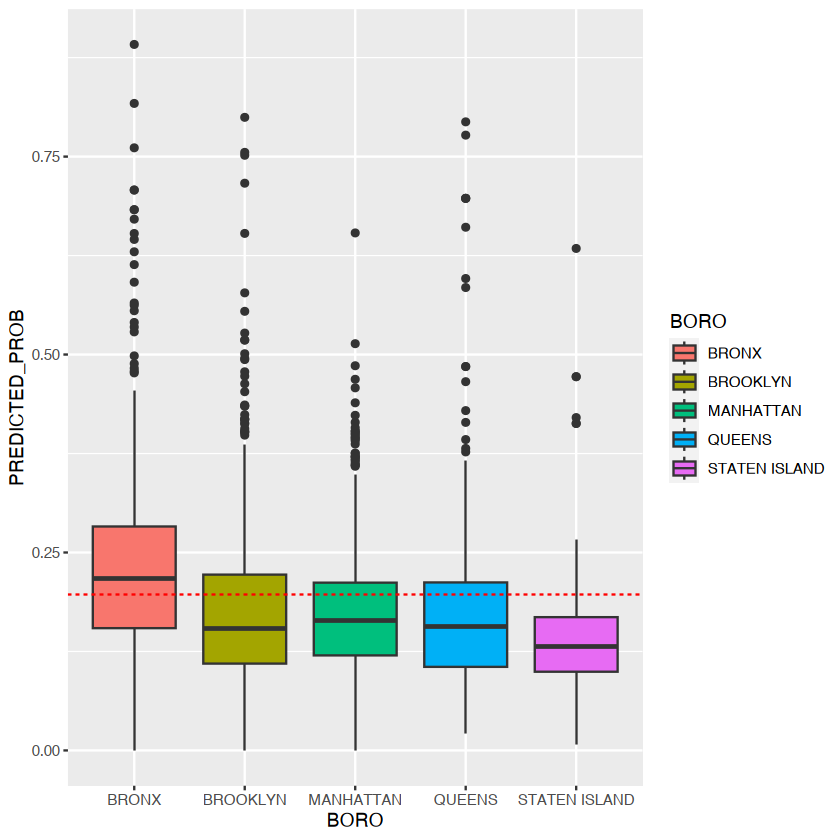

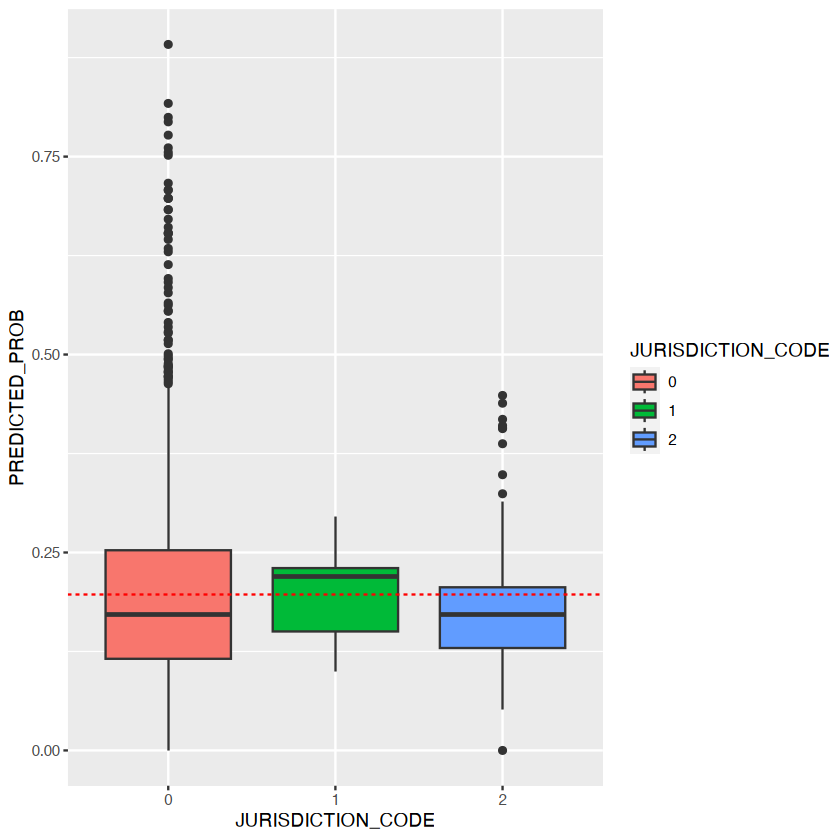

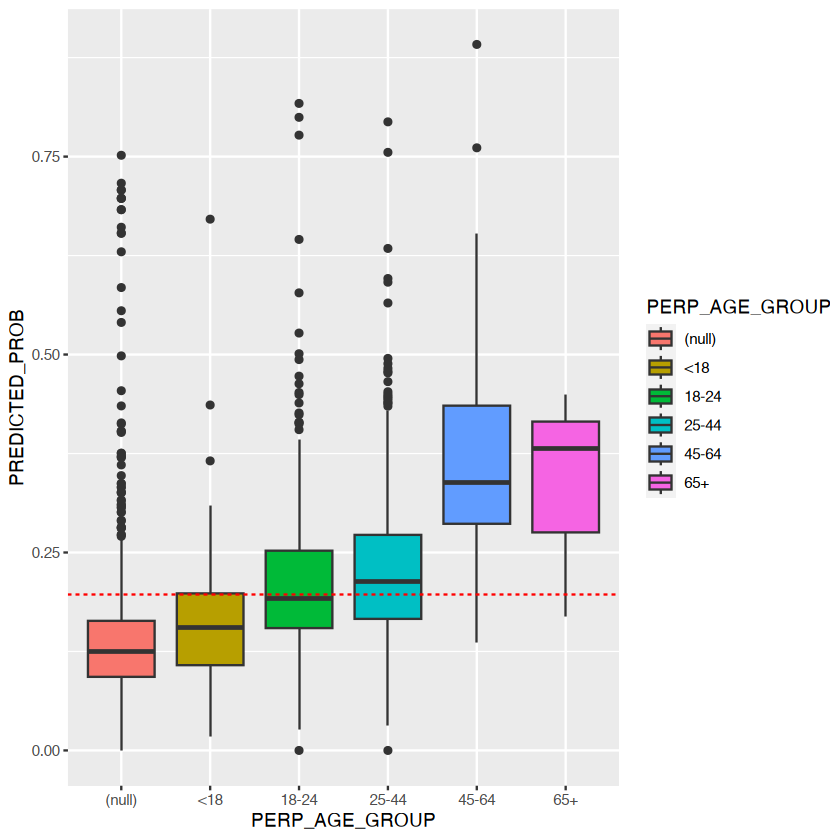

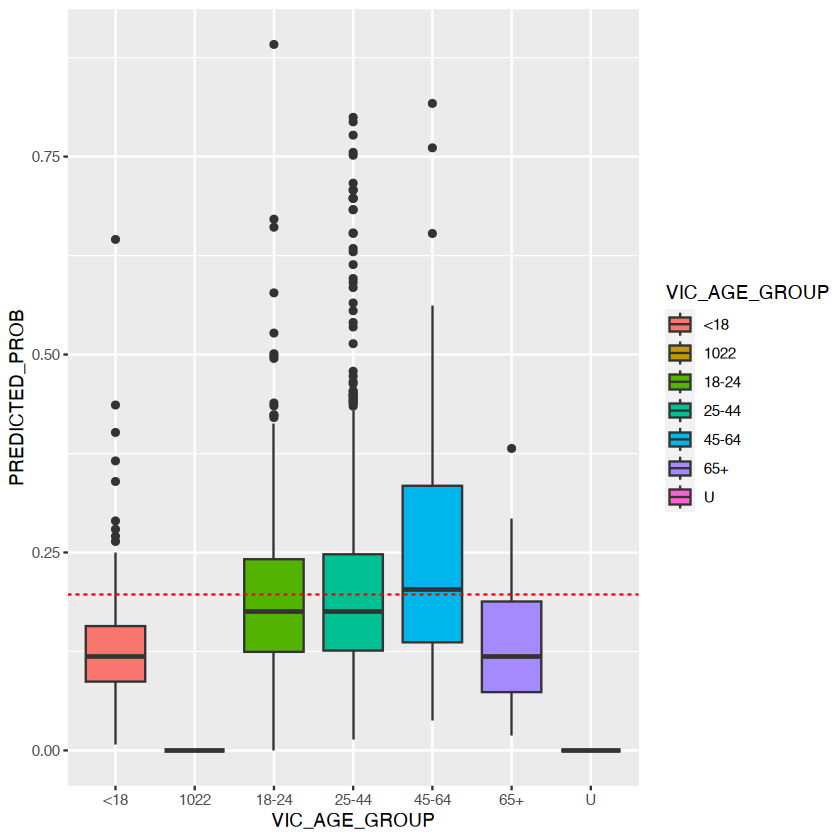

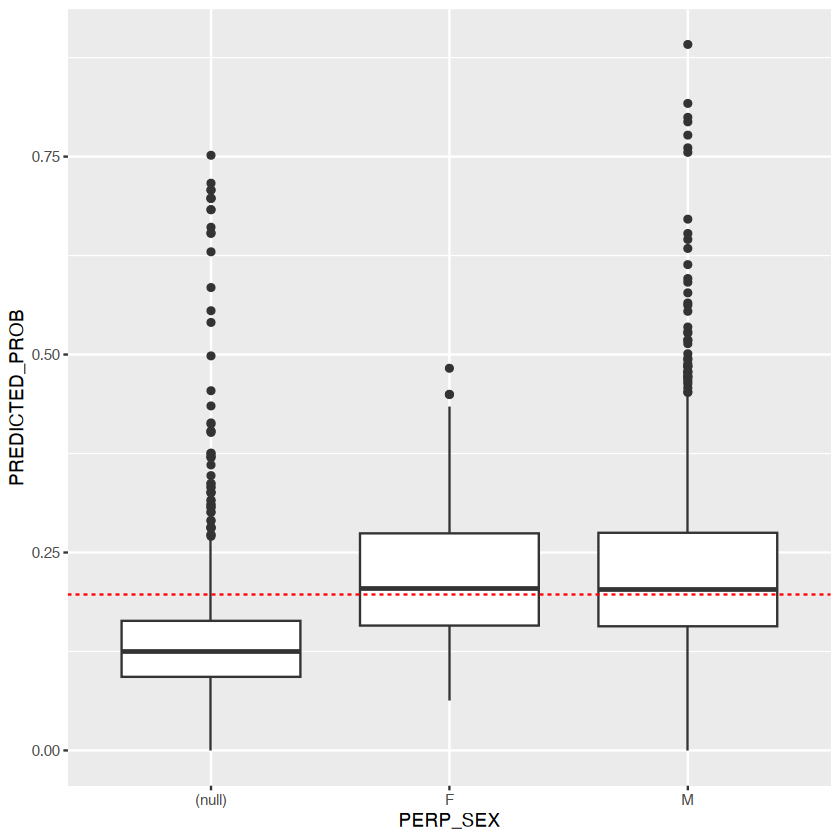

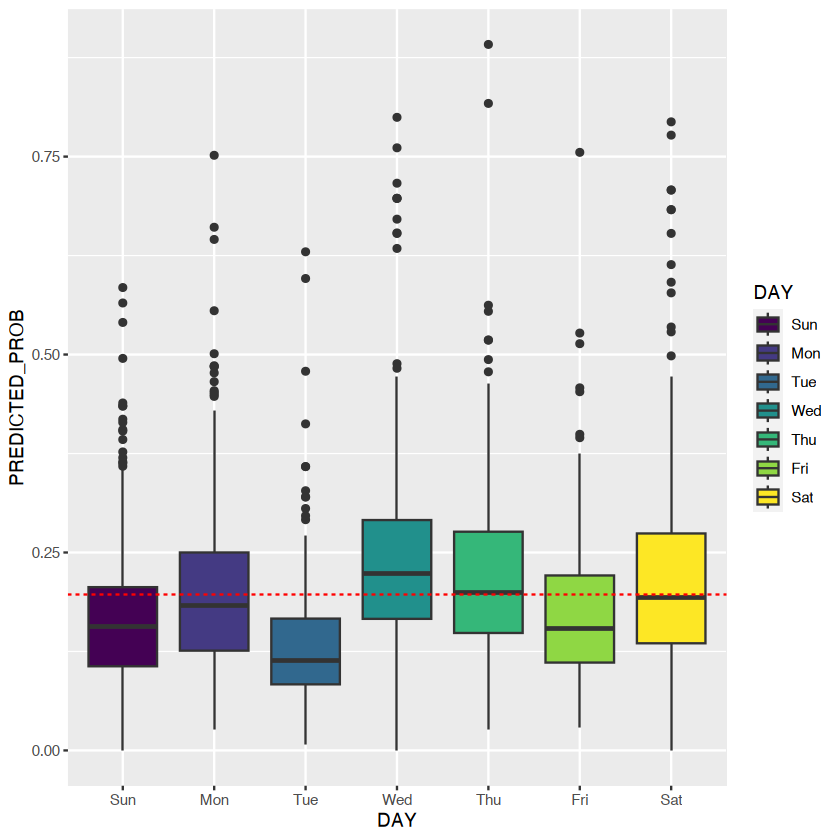

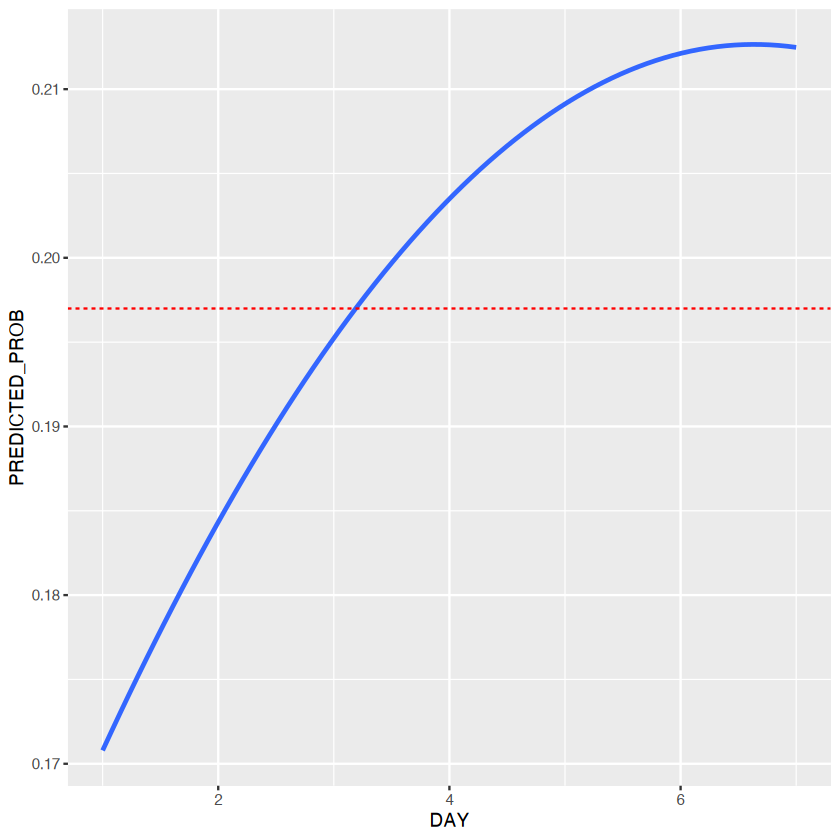

In [23]:
ggplot(nypd_results, aes(x = BORO, y = PREDICTED_PROB)) +
  geom_boxplot(aes(fill = BORO)) +
  geom_hline(yintercept = murder_true_prob, linetype = "dashed", color = "red")

ggplot(nypd_results, aes(x = JURISDICTION_CODE, y = PREDICTED_PROB)) +
  geom_boxplot(aes(fill = JURISDICTION_CODE)) +
  geom_hline(yintercept = murder_true_prob, linetype = "dashed", color = "red")

ggplot(nypd_results, aes(x = PERP_AGE_GROUP, y = PREDICTED_PROB)) +
  geom_boxplot(aes(fill = PERP_AGE_GROUP)) +
  geom_hline(yintercept = murder_true_prob, linetype = "dashed", color = "red")

ggplot(nypd_results, aes(x = VIC_AGE_GROUP, y = PREDICTED_PROB)) +
  geom_boxplot(aes(fill = VIC_AGE_GROUP)) +
  geom_hline(yintercept = murder_true_prob, linetype = "dashed", color = "red")

ggplot(nypd_results, aes(x = PERP_SEX, y = PREDICTED_PROB)) +
  geom_boxplot(aes(x = PERP_SEX)) +
  geom_hline(yintercept = murder_true_prob, linetype = "dashed", color = "red")

ggplot(nypd_results, aes(x = DAY, y = PREDICTED_PROB)) +
  geom_boxplot(aes(fill = DAY)) +
  geom_hline(yintercept = murder_true_prob, linetype = "dashed", color = "red")


ggplot(nypd_results, aes(x = DAY, y = PREDICTED_PROB)) +
  geom_smooth(aes(x = unclass(DAY)),
              formula = y ~ poly(x, 2),
              method = lm, se = FALSE) +
  geom_hline(yintercept = murder_true_prob, linetype = "dashed", color = "red")

### 7. Conclusion and Bias Discussion

The topic of this project shows how bias may affect the results, especially in determining what predictors may be more useful when determining the probability of murder related shootings. New York City is highly portrayed in media and is very diverse. The city has somewhat of a reputation of being inhabited by rude people, hard workers, or even criminals like the Mafia, to name a few examples of stereotypes. Having visited New York City myself, and have seen New York City portrayed in various TV shows and movies, I have my own preconceptions about shootings in New York City. I thought perpetrator race would have played a significant role in estimating probability. I also thought that the the Bronx would have been a significant factor, given that the media always portrays the Bronx as a dangerous place. These biases were quickly dispelled once I made bar plots for PERP_RACE and BORO and ran the regression and saw what really factors into the probability of a murder related shooting. 

With the bar plots, I noticed almost equal amounts of shooting incidents where the perpetrator's race was black and unknown. The unknown data is possibly due to a perpetrator not being identified or arrested. Since there is a good amount of unknown race data, it makes sense that the perpetrator's race does not come out as significant in the regression. Another bar plot showed that more shooting incidents occurred in Brooklyn, compared to my initial assumption of the Bronx.

If I had gone with my initial preconceptions, my estimates would have been far off. Additionally, if a model made with my preconceptions was used to impact things like public policy or police staffing, it would have incorrectly portrayed the Bronx and black individuals in the wrong light, when those variables should not even be factored in. When utilizing data, one must also consider bias that comes with data collection itself. These shooting incidents are from real police encounters, and there may be systemic bias with how police respond to such incidents. Perpetrator identification can also be heavily based on witness or victim account, and the victim's own personal bias therefore also affects this data set. This shows that one must always verify with the data before making any assumptions, and that the context in which data is collected must be kept in mind. 